# Will it rain in Australia Tomorrow?
### Problem statement: Predict whether or not it will rain tomorrow by training a binary classification model on target RainTomorrow.


## Roadmap for the problem:
#### 1. Reading and understanding data
#### 2. Data Cleaning- Missing value treatment and outlier treatment
#### 3. Data preparation along with some data visualization: One hot encoding/lable encoding of categorical variables, Scaling variables wherever required.
#### 4. Model Building
#####    a) Logistic Regression 
#####    b) Decesion Tree Classifier
#####    c) Random Forest Classifier
#### 5. Model selection and Model evaluation
#####    a) Choosing the best performing model and Evaluating the model
#####    b) Evaluation metrics used - Acuracy, Sensitivity, specificity and AUC Score

### Note: As per problem statement we need to drop Risk-MM variable as it will leak the answers to your model and reduce its predictability.

In [1]:
# library to be used:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

# Reading and understanding data:

In [2]:
# Let us load/fetch the data
# Removing RISK_MM as it is asked in the problem statement to drop the variable
Aus_Rain = pd.read_csv("../input/weatherAUS.csv", parse_dates=['Date'], index_col=0).drop('RISK_MM', axis=1)

#Let us see top few rows:
Aus_Rain.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,,,,
2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


##### Inspecting various aspects of Aus_rain dataframe:

In [3]:
Aus_Rain.shape # shape of the dataframe: 142193 rows and 22 columns

(142193, 22)

In [4]:
# Type of columns in data frame and its count:
Aus_Rain.get_dtype_counts() 

object      6
float64    16
dtype: int64

In [5]:
# columns of the data frame:
Aus_Rain.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [6]:
# Let us take whole info about the data frame:
Aus_Rain.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142193 entries, 2008-12-01 to 2017-06-24
Data columns (total 22 columns):
Location         142193 non-null object
MinTemp          141556 non-null float64
MaxTemp          141871 non-null float64
Rainfall         140787 non-null float64
Evaporation      81350 non-null float64
Sunshine         74377 non-null float64
WindGustDir      132863 non-null object
WindGustSpeed    132923 non-null float64
WindDir9am       132180 non-null object
WindDir3pm       138415 non-null object
WindSpeed9am     140845 non-null float64
WindSpeed3pm     139563 non-null float64
Humidity9am      140419 non-null float64
Humidity3pm      138583 non-null float64
Pressure9am      128179 non-null float64
Pressure3pm      128212 non-null float64
Cloud9am         88536 non-null float64
Cloud3pm         85099 non-null float64
Temp9am          141289 non-null float64
Temp3pm          139467 non-null float64
RainToday        140787 non-null object
RainTomorrow     1421

In [7]:
# let us see the stastistical summary of the data frame:
Aus_Rain.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


In [8]:
# let us see how many years of data is provided to us:
Aus_Rain.index.min(), Aus_Rain.index.max()

(Timestamp('2007-11-01 00:00:00'), Timestamp('2017-06-25 00:00:00'))

##### We have been provided past 10 years data.

# Visualizing the Data and its distribution:

##### Let us first see the missing value distribution in the plot:

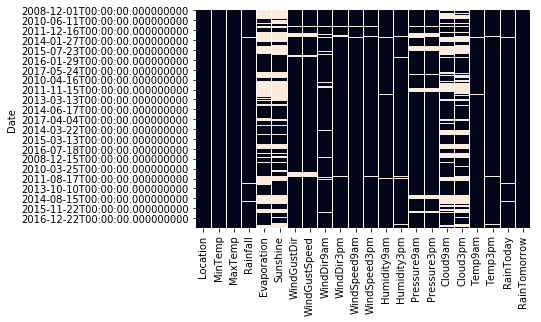

In [9]:
sns.heatmap(Aus_Rain.isnull(), cbar = False)

###### Here we can see that there are lots of missing values in data
###### Evaporation, Sunshine, Cloud9am, Cloud3pm has maximum percentage of missing values.

## Let us first handle the missing values in the data:

In [10]:
# summing up the missing value cloumn wise
Aus_Rain.isnull().sum()

Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
dtype: int64

In [11]:
# let us see if any row has all missing values:
Aus_Rain.isnull().all(axis = 1).sum()

0

In [12]:
# let us see the sum of missing vvalues in each rows:
Aus_Rain.isnull().sum(axis = 1)

Date
2008-12-01    3
2008-12-02    4
2008-12-03    3
2008-12-04    4
2008-12-05    2
2008-12-06    4
2008-12-07    3
2008-12-08    4
2008-12-09    4
2008-12-10    4
2008-12-11    4
2008-12-12    2
2008-12-13    2
2008-12-14    3
2008-12-16    7
2008-12-17    2
2008-12-18    2
2008-12-19    3
2008-12-20    4
2008-12-21    4
2008-12-22    3
2008-12-23    4
2008-12-24    3
2008-12-25    4
2008-12-26    3
2008-12-27    4
2008-12-28    4
2008-12-29    4
2008-12-30    2
2008-12-31    3
             ..
2017-05-26    3
2017-05-27    4
2017-05-28    3
2017-05-29    2
2017-05-30    2
2017-05-31    4
2017-06-01    4
2017-06-02    4
2017-06-03    4
2017-06-04    4
2017-06-05    4
2017-06-06    4
2017-06-07    4
2017-06-08    4
2017-06-09    4
2017-06-10    4
2017-06-11    4
2017-06-12    4
2017-06-13    4
2017-06-14    4
2017-06-15    4
2017-06-16    4
2017-06-17    4
2017-06-18    3
2017-06-19    4
2017-06-20    4
2017-06-21    4
2017-06-22    4
2017-06-23    4
2017-06-24    2
Length: 142193, dty

#### Treating missing values in column:

In [13]:
# taking the percentage of missing values column wise:
round(100*(Aus_Rain.isnull().sum()/len(Aus_Rain.index)),2)

Location          0.00
MinTemp           0.45
MaxTemp           0.23
Rainfall          0.99
Evaporation      42.79
Sunshine         47.69
WindGustDir       6.56
WindGustSpeed     6.52
WindDir9am        7.04
WindDir3pm        2.66
WindSpeed9am      0.95
WindSpeed3pm      1.85
Humidity9am       1.25
Humidity3pm       2.54
Pressure9am       9.86
Pressure3pm       9.83
Cloud9am         37.74
Cloud3pm         40.15
Temp9am           0.64
Temp3pm           1.92
RainToday         0.99
RainTomorrow      0.00
dtype: float64

##### We can see Evaporation, Sunshine, Cloud9am, Cloud3pm has great percentage of missing values as 43%, 48%,38%,40% respectively.
##### Let us remove the columns having missing values > 30%

In [14]:
# removing columns with high percentage of missing values:
Aus_Rain = Aus_Rain.drop('Evaporation', axis = 1)
Aus_Rain = Aus_Rain.drop('Sunshine', axis = 1)
Aus_Rain = Aus_Rain.drop('Cloud9am', axis = 1)
Aus_Rain = Aus_Rain.drop('Cloud3pm', axis = 1)


In [15]:
round(100*(Aus_Rain.isnull().sum()/len(Aus_Rain.index)),2)

Location         0.00
MinTemp          0.45
MaxTemp          0.23
Rainfall         0.99
WindGustDir      6.56
WindGustSpeed    6.52
WindDir9am       7.04
WindDir3pm       2.66
WindSpeed9am     0.95
WindSpeed3pm     1.85
Humidity9am      1.25
Humidity3pm      2.54
Pressure9am      9.86
Pressure3pm      9.83
Temp9am          0.64
Temp3pm          1.92
RainToday        0.99
RainTomorrow     0.00
dtype: float64

#### Treating missing values of rows:

In [16]:
# Let us see how many rows has more than 5 missing values
len(Aus_Rain[Aus_Rain.isnull().sum(axis=1) > 5].index)

3135

In [17]:
# let us see the percentage:
round(100*(len(Aus_Rain[Aus_Rain.isnull().sum(axis=1)>5].index)/len(Aus_Rain.index)),2)

2.2

##### Let us remove these 3135 rows which contain > 5 missing values in each rows, which accounts to only 2.2%

In [18]:
Aus_Rain = Aus_Rain[Aus_Rain.isnull().sum(axis = 1) <= 5]

# again looking missing value percentage of each column:
round(100*(Aus_Rain.isnull().sum()/len(Aus_Rain.index)),2)

Location         0.00
MinTemp          0.14
MaxTemp          0.08
Rainfall         0.80
WindGustDir      4.74
WindGustSpeed    4.70
WindDir9am       5.89
WindDir3pm       0.79
WindSpeed9am     0.12
WindSpeed3pm     0.15
Humidity9am      0.80
Humidity3pm      1.22
Pressure9am      8.49
Pressure3pm      8.49
Temp9am          0.21
Temp3pm          0.61
RainToday        0.80
RainTomorrow     0.00
dtype: float64

#### There are still lots of variable which contain great %age of missing value like WindGustSpeed, Pressure9am, Pressure3pm with 4.70% ,8.49%, 8.49% respectively. Let us deal with the one by one.

In [19]:
# Let us see the summary of PPressure 9am, Pressure3pm, WindGustSpeed as they are numeric variable:
Aus_Rain.loc[:, ['Pressure9am','Pressure3pm', 'WindGustSpeed']].describe()

,Pressure9am,Pressure3pm,WindGustSpeed
count,127257.000000,127254.000000,132523.000000
mean,1017.648803,1015.250504,39.968971
std,7.105719,7.037671,13.575583
min,980.500000,977.100000,6.000000
25%,1012.900000,1010.400000,31.000000
50%,1017.600000,1015.200000,39.000000
75%,1022.400000,1020.000000,48.000000
max,1041.000000,1039.600000,135.000000


##### Difference between mean and median is 0 and difference between 25% and 75% is also quiet less for all the 3 variables. Therefore we will impute Nan values in these variable with mean.

In [20]:
# Let us replace NaN with the mean value of each variable respectively:
Aus_Rain.loc[np.isnan(Aus_Rain['Pressure9am']), ['Pressure9am']] = Aus_Rain.Pressure9am.mean()
Aus_Rain.loc[np.isnan(Aus_Rain['Pressure3pm']), ['Pressure3pm']] = Aus_Rain.Pressure3pm.mean()
Aus_Rain.loc[np.isnan(Aus_Rain['WindGustSpeed']), ['WindGustSpeed']] = Aus_Rain.WindGustSpeed.mean()

In [21]:
# again looking missing value percentage of each column:
round(100*(Aus_Rain.isnull().sum()/len(Aus_Rain.index)),2)

Location         0.00
MinTemp          0.14
MaxTemp          0.08
Rainfall         0.80
WindGustDir      4.74
WindGustSpeed    0.00
WindDir9am       5.89
WindDir3pm       0.79
WindSpeed9am     0.12
WindSpeed3pm     0.15
Humidity9am      0.80
Humidity3pm      1.22
Pressure9am      0.00
Pressure3pm      0.00
Temp9am          0.21
Temp3pm          0.61
RainToday        0.80
RainTomorrow     0.00
dtype: float64

In [22]:
Aus_Rain.loc[:, ['MinTemp','MaxTemp', 'Rainfall', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Temp9am', 'Temp3pm']].describe()

,MinTemp,MaxTemp,Rainfall,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Temp9am,Temp3pm
count,138866.000000,138947.000000,137947.000000,138885.000000,138854.000000,137941.000000,137366.000000,138761.000000,138215.000000
mean,12.193587,23.264887,2.331707,14.056010,18.676761,68.742049,51.438900,16.993642,21.699105
std,6.410163,7.114334,8.402119,8.835119,8.774355,19.087046,20.786924,6.509061,6.937772
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.200000,-5.400000
25%,7.600000,17.900000,0.000000,7.000000,13.000000,57.000000,37.000000,12.300000,16.600000
50%,12.000000,22.700000,0.000000,13.000000,19.000000,70.000000,52.000000,16.700000,21.100000
75%,16.900000,28.300000,0.600000,19.000000,24.000000,83.000000,66.000000,21.600000,26.400000
max,33.900000,48.100000,371.000000,87.000000,87.000000,100.000000,100.000000,40.200000,46.700000


##### Here also for all the numeric variable above difference between mean and median is less and difference between 25% and 75% is also quiet less for all the variables. Therefore we will impute Nan values in these variable with mean.

In [23]:
# Creating Data frame for all numerical variables
Num_Var = Aus_Rain.loc[:,['MinTemp','MaxTemp', 'Rainfall', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Temp9am', 'Temp3pm']]
Num_Var.head()

,MinTemp,MaxTemp,Rainfall,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Temp9am,Temp3pm
Date,,,,,,,,,
2008-12-01,13.4,22.9,0.6,20.0,24.0,71.0,22.0,16.9,21.8
2008-12-02,7.4,25.1,0.0,4.0,22.0,44.0,25.0,17.2,24.3
2008-12-03,12.9,25.7,0.0,19.0,26.0,38.0,30.0,21.0,23.2
2008-12-04,9.2,28.0,0.0,11.0,9.0,45.0,16.0,18.1,26.5
2008-12-05,17.5,32.3,1.0,7.0,20.0,82.0,33.0,17.8,29.7


In [24]:
# Droping Numerical Variables from the main data frame Aus_Rain
Aus_Rain = Aus_Rain.drop(['MinTemp','MaxTemp', 'Rainfall', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Temp9am', 'Temp3pm'], 
                         axis = 1)
Aus_Rain.head()

,Location,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow
Date,,,,,,,,,
2008-12-01,Albury,W,44.0,W,WNW,1007.7,1007.1,No,No
2008-12-02,Albury,WNW,44.0,NNW,WSW,1010.6,1007.8,No,No
2008-12-03,Albury,WSW,46.0,W,WSW,1007.6,1008.7,No,No
2008-12-04,Albury,NE,24.0,SE,E,1017.6,1012.8,No,No
2008-12-05,Albury,W,41.0,ENE,NW,1010.8,1006.0,No,No


In [25]:
# Filling NaN values of the Numerical variables with its respective mean.
Num_Var = Num_Var.apply(lambda x: x.fillna(x.mean()),axis=0)
round(100*(Num_Var.isnull().sum()/len(Num_Var.index)),2)

MinTemp         0.0
MaxTemp         0.0
Rainfall        0.0
WindSpeed9am    0.0
WindSpeed3pm    0.0
Humidity9am     0.0
Humidity3pm     0.0
Temp9am         0.0
Temp3pm         0.0
dtype: float64

In [26]:
# Concatinating the dataframe Num_Var and Aus_Rain

Aus_Rain_New = pd.concat([Num_Var,Aus_Rain], axis = 1)
Aus_Rain_New.head()

,MinTemp,MaxTemp,Rainfall,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Temp9am,Temp3pm,Location,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow
Date,,,,,,,,,,,,,,,,,,
2008-12-01,13.4,22.9,0.6,20.0,24.0,71.0,22.0,16.9,21.8,Albury,W,44.0,W,WNW,1007.7,1007.1,No,No
2008-12-02,7.4,25.1,0.0,4.0,22.0,44.0,25.0,17.2,24.3,Albury,WNW,44.0,NNW,WSW,1010.6,1007.8,No,No
2008-12-03,12.9,25.7,0.0,19.0,26.0,38.0,30.0,21.0,23.2,Albury,WSW,46.0,W,WSW,1007.6,1008.7,No,No
2008-12-04,9.2,28.0,0.0,11.0,9.0,45.0,16.0,18.1,26.5,Albury,NE,24.0,SE,E,1017.6,1012.8,No,No
2008-12-05,17.5,32.3,1.0,7.0,20.0,82.0,33.0,17.8,29.7,Albury,W,41.0,ENE,NW,1010.8,1006.0,No,No


In [27]:
# again looking missing value percentage of each column:
round(100*(Aus_Rain_New.isnull().sum()/len(Aus_Rain_New.index)),2)

MinTemp          0.00
MaxTemp          0.00
Rainfall         0.00
WindSpeed9am     0.00
WindSpeed3pm     0.00
Humidity9am      0.00
Humidity3pm      0.00
Temp9am          0.00
Temp3pm          0.00
Location         0.00
WindGustDir      4.74
WindGustSpeed    0.00
WindDir9am       5.89
WindDir3pm       0.79
Pressure9am      0.00
Pressure3pm      0.00
RainToday        0.80
RainTomorrow     0.00
dtype: float64

##### Dealing with missing values of categorical variable like WindGustDir, WindDir9am, WindDir3pm, RainToday. Replacing NaN values with mean or median will not make much sense as they are fractional values. Therefore replacing NaN values with mode of the varibales repectively.

In [28]:
Aus_Rain_New['WindGustDir'].value_counts()

W      9733
SE     9292
E      9044
N      9017
SSE    8983
S      8926
WSW    8864
SW     8769
SSW    8594
WNW    8039
NW     7968
ENE    7964
ESE    7283
NE     7041
NNW    6547
NNE    6409
Name: WindGustDir, dtype: int64

In [29]:
# maximum count is of W . Therefore replacing NaN values with W:
Aus_Rain_New.loc[pd.isnull(Aus_Rain_New['WindGustDir']), ['WindGustDir']] = 'W'
round(100*(Aus_Rain_New.isnull().sum()/len(Aus_Rain_New.index)),2)

MinTemp          0.00
MaxTemp          0.00
Rainfall         0.00
WindSpeed9am     0.00
WindSpeed3pm     0.00
Humidity9am      0.00
Humidity3pm      0.00
Temp9am          0.00
Temp3pm          0.00
Location         0.00
WindGustDir      0.00
WindGustSpeed    0.00
WindDir9am       5.89
WindDir3pm       0.79
Pressure9am      0.00
Pressure3pm      0.00
RainToday        0.80
RainTomorrow     0.00
dtype: float64

In [30]:
# doing same for other variables:
Aus_Rain_New['WindDir9am'].value_counts()

N      11315
SE      9001
E       8957
SSE     8940
S       8421
NW      8309
W       8166
SW      8106
NNE     7925
NNW     7797
ENE     7695
ESE     7524
NE      7398
SSW     7370
WNW     7151
WSW     6786
Name: WindDir9am, dtype: int64

In [31]:
# maximum count is of N . Therefore replacing NaN values with N:
Aus_Rain_New.loc[pd.isnull(Aus_Rain_New['WindDir9am']), ['WindDir9am']] = 'N'

In [32]:
Aus_Rain_New['WindDir3pm'].value_counts()


SE     10596
W       9860
S       9575
WSW     9292
SW      9158
SSE     9128
N       8650
WNW     8621
NW      8424
ESE     8367
E       8315
NE      8137
SSW     8000
NNW     7717
ENE     7691
NNE     6426
Name: WindDir3pm, dtype: int64

In [33]:
# maximum count is of SE . Therefore replacing NaN values with SE:
Aus_Rain_New.loc[pd.isnull(Aus_Rain_New['WindDir3pm']), ['WindDir3pm']] = 'SE'

In [34]:
Aus_Rain_New['RainToday'].value_counts()

No     107266
Yes     30681
Name: RainToday, dtype: int64

In [35]:
# maximum count is of NO . Therefore replacing NaN values with NO:
Aus_Rain_New.loc[pd.isnull(Aus_Rain_New['RainToday']), ['RainToday']] = 'No'
round(100*(Aus_Rain_New.isnull().sum()/len(Aus_Rain_New.index)),2)

MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Temp9am          0.0
Temp3pm          0.0
Location         0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
Pressure9am      0.0
Pressure3pm      0.0
RainToday        0.0
RainTomorrow     0.0
dtype: float64

### We have treated missing values. Now let us see how many rows and columns are there in the data frame:

In [36]:
# let us see how much data we have lost: we have 142193 rows in original data set
100-100*Aus_Rain_New.shape[0]/142193


2.204749882202364

In [37]:
Aus_Rain_New.shape

(139058, 18)

###### Only 2.20 % data is lost.

In [38]:
# Creating a Aus_Rain_New data frame into other dataframe for further use
Aus_Rain_Classify = Aus_Rain_New

In [39]:
Aus_Rain_New.dtypes

MinTemp          float64
MaxTemp          float64
Rainfall         float64
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Temp9am          float64
Temp3pm          float64
Location          object
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
Pressure9am      float64
Pressure3pm      float64
RainToday         object
RainTomorrow      object
dtype: object

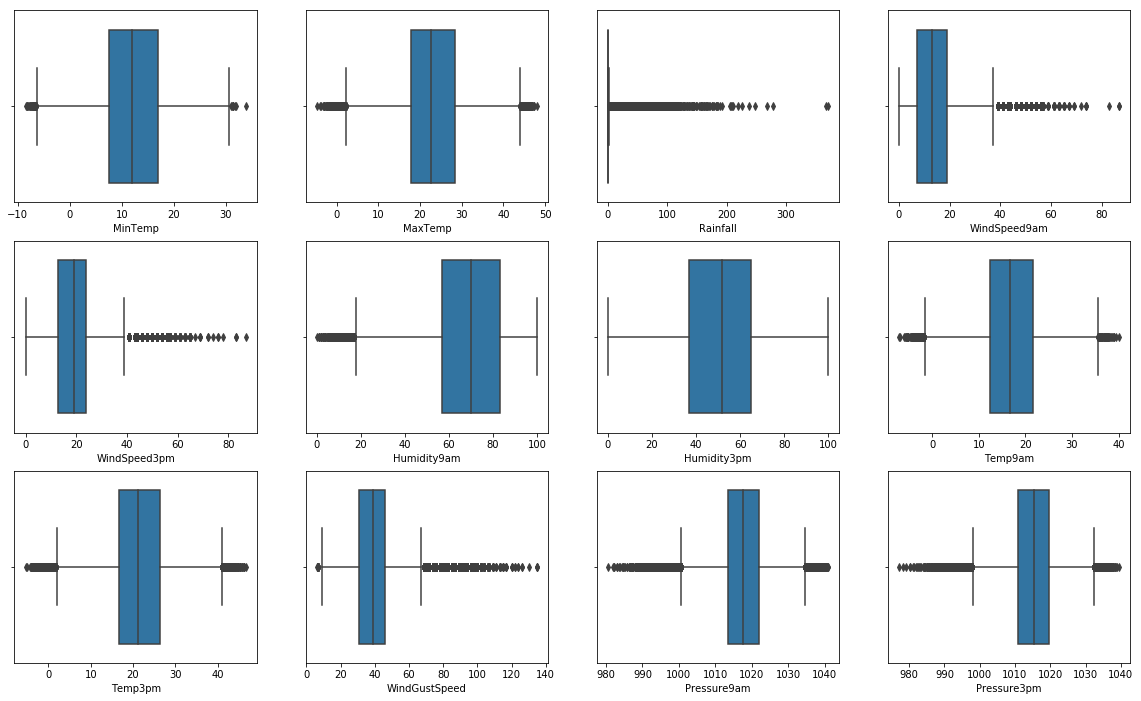

In [40]:
plt.figure(figsize=(20, 12))
plt.subplot(3,4,1)
sns.boxplot(Aus_Rain_New.MinTemp)
plt.subplot(3,4,2)
sns.boxplot(Aus_Rain_New.MaxTemp)
plt.subplot(3,4,3)
sns.boxplot(Aus_Rain_New.Rainfall)
plt.subplot(3,4,4)
sns.boxplot(Aus_Rain_New.WindSpeed9am)
plt.subplot(3,4,5)
sns.boxplot(Aus_Rain_New.WindSpeed3pm)
plt.subplot(3,4,6)
sns.boxplot(Aus_Rain_New.Humidity9am)
plt.subplot(3,4,7)
sns.boxplot(Aus_Rain_New.Humidity3pm)
plt.subplot(3,4,8)
sns.boxplot(Aus_Rain_New.Temp9am)
plt.subplot(3,4,9)
sns.boxplot(Aus_Rain_New.Temp3pm)
plt.subplot(3,4,10)
sns.boxplot(Aus_Rain_New.WindGustSpeed)
plt.subplot(3,4,11)
sns.boxplot(Aus_Rain_New.Pressure9am)
plt.subplot(3,4,12)
sns.boxplot(Aus_Rain_New.Pressure3pm)

### We can see there are outliers in some variable. Thus we need to treat the outliers:

In [41]:
Aus_Rain_New.RainTomorrow.value_counts()/len(Aus_Rain_New.index)

No     0.777129
Yes    0.222871
Name: RainTomorrow, dtype: float64

In [42]:
# using z-score test to remove outliers:

z = np.abs(stats.zscore(Aus_Rain_New._get_numeric_data()))
print(z)
Aus_Rain_New= Aus_Rain_New[(z < 3).all(axis=1)]
print(Aus_Rain_New.shape)

[[0.18833387 0.0513097  0.20693266 ... 0.30416649 1.46359738 1.2106524 ]
 [0.74833006 0.25804974 0.27863047 ... 0.30416649 1.03696993 1.10667641]
 [0.11027854 0.34242049 0.27863047 ... 0.45507909 1.47830867 0.972993  ]
 ...
 [1.34155055 0.28617332 0.27863047 ... 1.35587206 0.86078667 0.57179313]
 [1.06055137 0.511162   0.27863047 ... 0.22402759 0.49300438 0.23015774]
 [0.6858858  0.52522379 0.27863047 ... 0.90313427 0.25762372 0.1855966 ]]
(132367, 18)


##### The data contain 79% No rainfall and 21% rainfall. The data is imbalanced, however it is not that imbalanced for not carrying out our analysis. so we will carry out our analysis using this data only.

#### Let us visualize categorical variables:

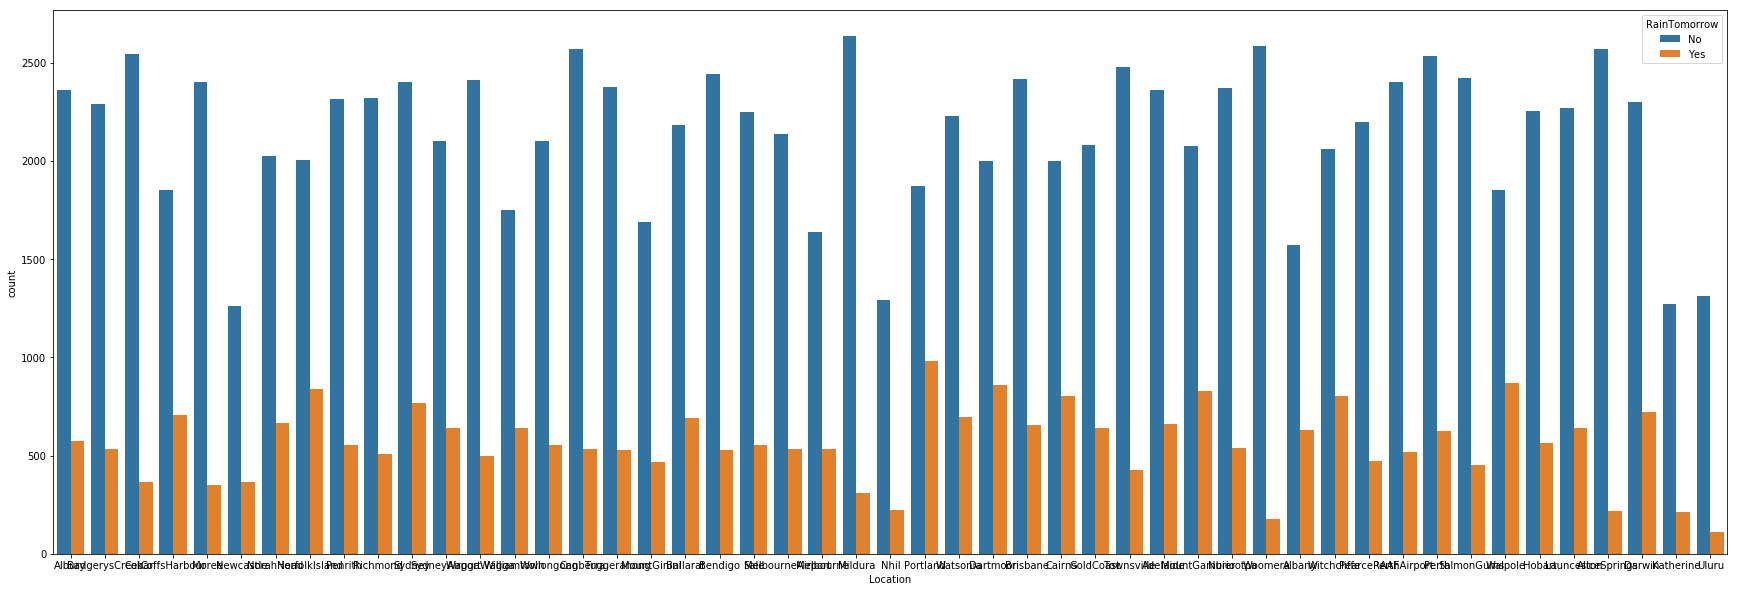

In [43]:
plt.figure(figsize=(30, 10))
sns.countplot(x = 'Location', hue = 'RainTomorrow', data = Aus_Rain_New)

##### Portland Location of Australia recieved rainfall highest no. of times.


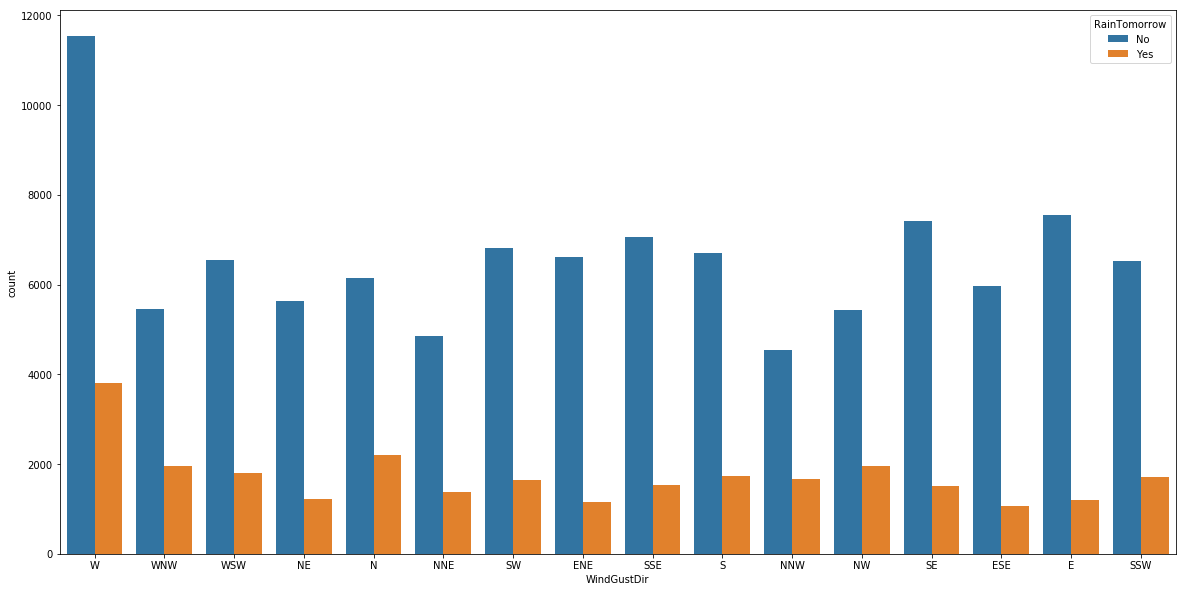

In [44]:
plt.figure(figsize=(20, 10))
sns.countplot(x = 'WindGustDir', hue = 'RainTomorrow', data = Aus_Rain_New)

##### W windgustdir recieved highest no. of times rainfall

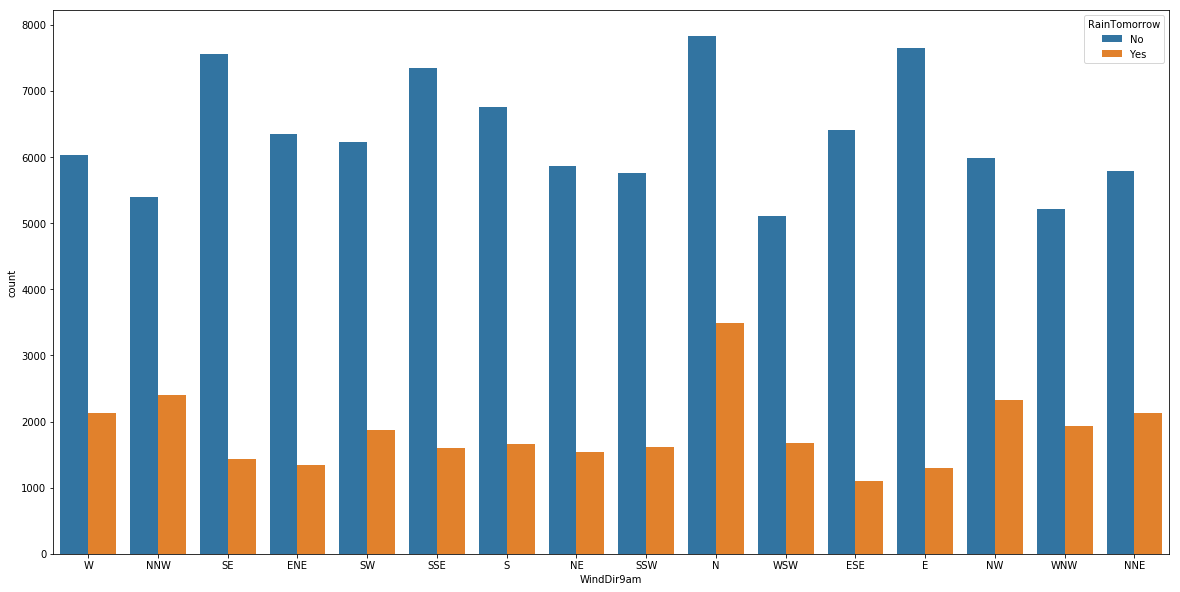

In [45]:
plt.figure(figsize=(20, 10))
sns.countplot(x = 'WindDir9am', hue = 'RainTomorrow', data = Aus_Rain)

##### when WindDir9am is N it recieved highest no. of times rainfall

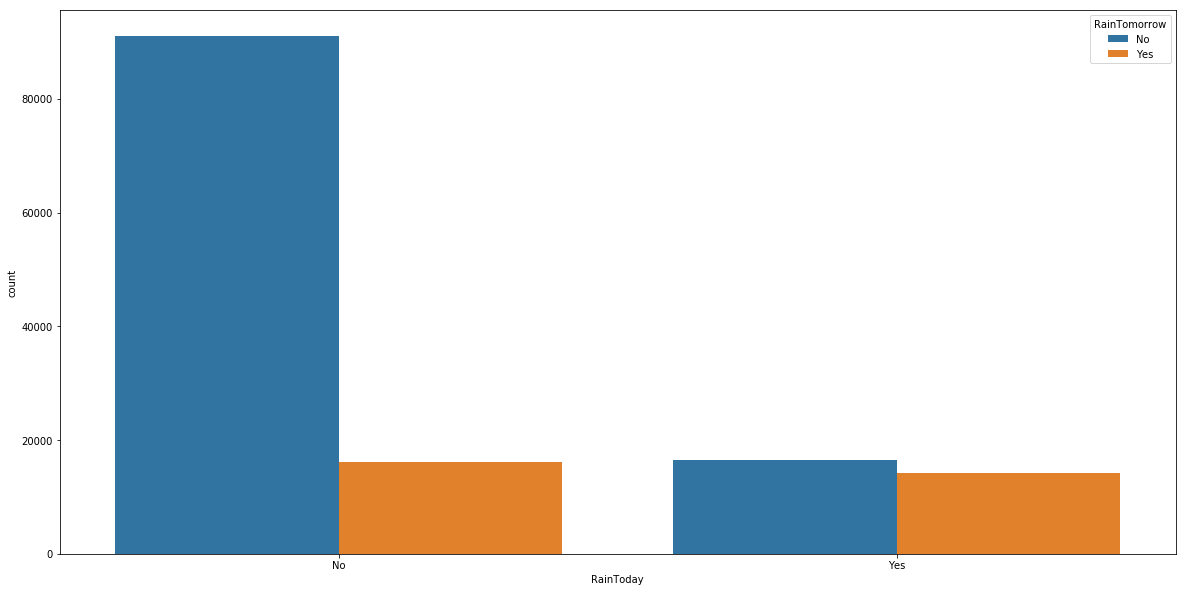

In [46]:
plt.figure(figsize=(20, 10))
sns.countplot(x = 'RainToday', hue = 'RainTomorrow', data = Aus_Rain)

##### when there is No rain today there is higher probablity that rain will not come tomorrow. If it rains today then it may rain tomorrow.

In [47]:
Aus_Rain_New.head()

,MinTemp,MaxTemp,Rainfall,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Temp9am,Temp3pm,Location,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow
Date,,,,,,,,,,,,,,,,,,
2008-12-01,13.4,22.9,0.6,20.0,24.0,71.0,22.0,16.9,21.8,Albury,W,44.0,W,WNW,1007.7,1007.1,No,No
2008-12-02,7.4,25.1,0.0,4.0,22.0,44.0,25.0,17.2,24.3,Albury,WNW,44.0,NNW,WSW,1010.6,1007.8,No,No
2008-12-03,12.9,25.7,0.0,19.0,26.0,38.0,30.0,21.0,23.2,Albury,WSW,46.0,W,WSW,1007.6,1008.7,No,No
2008-12-04,9.2,28.0,0.0,11.0,9.0,45.0,16.0,18.1,26.5,Albury,NE,24.0,SE,E,1017.6,1012.8,No,No
2008-12-05,17.5,32.3,1.0,7.0,20.0,82.0,33.0,17.8,29.7,Albury,W,41.0,ENE,NW,1010.8,1006.0,No,No


#### Let us now create Dummy Variables:



In [48]:
# Droping Location as it is irrelavant in this prediction:
Aus_Rain_New = Aus_Rain_New.drop('Location', axis = 1)

# Converting binary variable yes/no to 1/0
Aus_Rain_New['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
Aus_Rain_New['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

# For multiple class variables:
cat_data = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
dummy = pd.get_dummies(Aus_Rain_New[cat_data], drop_first = True)

# Concatinating dummy and Aus_Rain_New
Final_Data = pd.concat([dummy, Aus_Rain_New], axis = 1)

In [49]:
# Droping 'WindGustDir', 'WindDir9am', 'WindDir3pm'
Final_Data = Final_Data.drop('WindGustDir', 1)
Final_Data = Final_Data.drop('WindDir9am', 1)
Final_Data = Final_Data.drop('WindDir3pm', 1)
Final_Data.head()

,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,MinTemp,MaxTemp,Rainfall,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Temp9am,Temp3pm,WindGustSpeed,Pressure9am,Pressure3pm,RainToday,RainTomorrow
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-12-01,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,13.4,22.9,0.6,20.0,24.0,71.0,22.0,16.9,21.8,44.0,1007.7,1007.1,0,0
2008-12-02,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7.4,25.1,0.0,4.0,22.0,44.0,25.0,17.2,24.3,44.0,1010.6,1007.8,0,0
2008-12-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,12.9,25.7,0.0,19.0,26.0,38.0,30.0,21.0,23.2,46.0,1007.6,1008.7,0,0
2008-12-04,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.2,28.0,0.0,11.0,9.0,45.0,16.0,18.1,26.5,24.0,1017.6,1012.8,0,0
2008-12-05,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,17.5,32.3,1.0,7.0,20.0,82.0,33.0,17.8,29.7,41.0,1010.8,1006.0,0,0


In [50]:
Final_Data.shape

(132367, 59)

## Test Train split:

In [51]:
X, y = Final_Data.drop('RainTomorrow', axis=1), Final_Data.RainTomorrow
print(X.head())
print(y.head())

            WindGustDir_ENE  WindGustDir_ESE    ...      Pressure3pm  RainToday
Date                                            ...                            
2008-12-01                0                0    ...           1007.1          0
2008-12-02                0                0    ...           1007.8          0
2008-12-03                0                0    ...           1008.7          0
2008-12-04                0                0    ...           1012.8          0
2008-12-05                0                0    ...           1006.0          0

[5 rows x 58 columns]
Date
2008-12-01    0
2008-12-02    0
2008-12-03    0
2008-12-04    0
2008-12-05    0
Name: RainTomorrow, dtype: int64


In [52]:
np.random.seed(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

##### Standardizing the variable by scaling:

In [53]:
Num_var = ['MinTemp' , 'MaxTemp', 'Rainfall', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Temp9am', 'Temp3pm', 'WindGustSpeed', 'Pressure9am', 'Pressure3pm']
scaler = StandardScaler()
X_train[Num_var] = scaler.fit_transform(X_train[Num_var])
X_train.head()

,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,MinTemp,MaxTemp,Rainfall,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Temp9am,Temp3pm,WindGustSpeed,Pressure9am,Pressure3pm,RainToday
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-11-24,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.391882,0.728782,-0.278045,-0.312035,0.095606,0.068046,0.441560,1.483797,0.771587,-0.753320,0.498715,0.692468,0
2016-08-24,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.052491,-1.235423,0.246251,-0.312035,-1.123702,0.552922,1.925656,-0.556559,-1.191143,0.344227,-0.720467,-1.245963,1
2010-07-31,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.658777,0.872154,-0.382904,0.666412,1.192982,0.337421,0.639439,1.281319,0.801102,0.175374,0.143763,0.103185,0
2015-07-03,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.638296,0.399025,-0.382904,0.177188,1.802636,-0.362955,-0.152079,0.860788,0.387896,0.428654,0.004869,-0.036382,0
2010-03-07,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.438981,0.556734,-0.330475,-0.556647,0.705259,0.930048,1.035198,0.907513,0.653528,-0.331186,-0.535275,-0.424068,0


###  Lets look at the corelation between each variable:

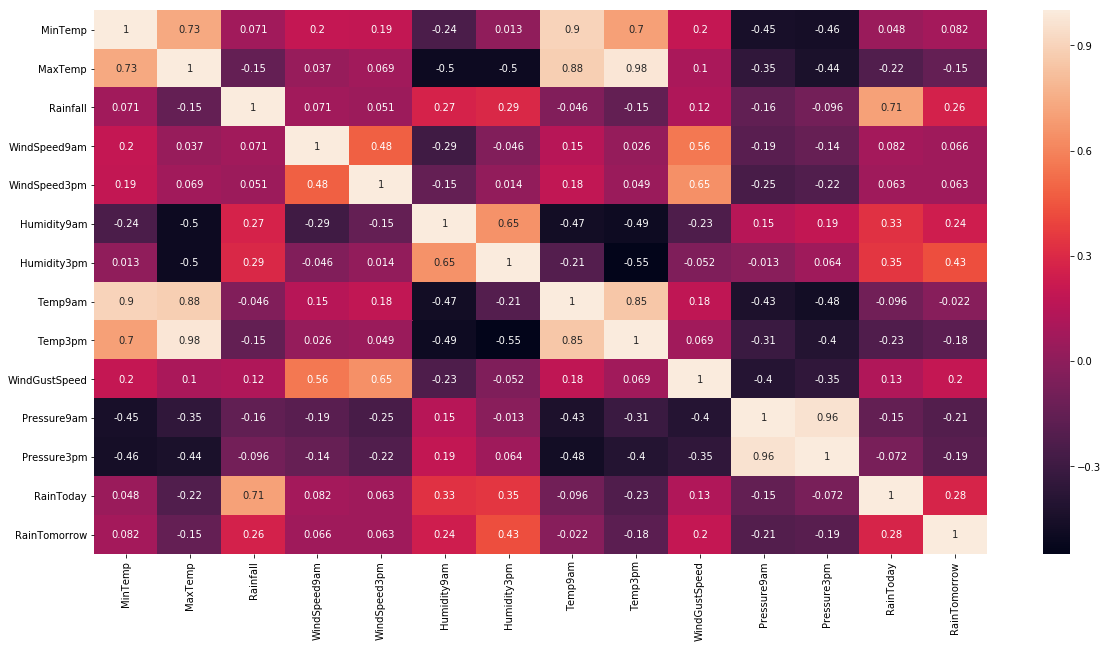

In [54]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,10))        
sns.heatmap(Aus_Rain_New.corr(),annot = True)

# Model Building:

In [55]:
# Lets build our first model:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           RainTomorrow   No. Observations:                92656
Model:                            GLM   Df Residuals:                    92597
Model Family:                Binomial   Df Model:                           58
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33367.
Date:                Wed, 29 May 2019   Deviance:                       66734.
Time:                        10:02:37   Pearson chi2:                 9.04e+04
No. Iterations:                     6   Covariance Type:             nonrobust
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.2336      0.066    -33.769      0.000      -2.363      -2.104
WindGustDir_ENE    -0.0361      0.065     -0.560      0.576      -0.163       0.090
WindGustDir_ESE     0.1737      0.066      2.646      0.008       0.045       0.302
WindGustDir_N       0.1276      0.066      1.938      0.053      -0.001       0.257
WindGustDir_NE     -0.2050      0.068     -3.026      0.002      -0.338      -0.072
WindGustDir_NNE    -0.2005      0.069     -2.887      0.004      -0.337      -0.064
WindGustDir_NNW     0.0877      0.070      1.259      0.208      -0.049       0.224
WindGustDir_NW     -0.0129      0.068     -0.191      0.848      -0.145       0.120
WindGustDir_S       0.0367      0.066      0.557      0.577      -0.092       0.166
WindGustDir_SE      0.1535      0.064      2.415      0.016       0.029       0.278
WindGustDir_SSE     0.1528      0.065      2.337      0.019       0.025       0.281
WindGustDir_SSW     0.0696      0.066      1.053      0.292      -0.060       0.199
WindGustDir_SW      0.1396      0.067      2.092      0.036       0.009       0.270
WindGustDir_W      -0.0575      0.058     -0.999      0.318      -0.170       0.055
WindGustDir_WNW     0.0671      0.067      1.001      0.317      -0.064       0.199
WindGustDir_WSW     0.0687      0.067      1.032      0.302      -0.062       0.199
WindDir9am_ENE      0.2664      0.065      4.129      0.000       0.140       0.393
WindDir9am_ESE     -0.1286      0.067     -1.929      0.054      -0.259       0.002
WindDir9am_N        0.2105      0.055      3.797      0.000       0.102       0.319
WindDir9am_NE       0.3144      0.065      4.854      0.000       0.187       0.441
WindDir9am_NNE      0.4459      0.063      7.092      0.000       0.323       0.569
WindDir9am_NNW      0.0271      0.063      0.431      0.666      -0.096       0.150
WindDir9am_NW       0.0144      0.062      0.231      0.817      -0.108       0.137
WindDir9am_S       -0.1812      0.065     -2.807      0.005      -0.308      -0.055
WindDir9am_SE      -0.1245      0.064     -1.957      0.050      -0.249       0.000
WindDir9am_SSE     -0.0904      0.063     -1.427      0.154      -0.215       0.034
WindDir9am_SSW     -0.0808      0.065     -1.240      0.215      -0.208       0.047
WindDir9am_SW       0.0406      0.063      0.642      0.521      -0.083       0.164
WindDir9am_W        0.0953      0.063      1.523      0.128      -0.027       0.218
WindDir9am_WNW      0.0740      0.064      1.149      0.251      -0.052       0.200
WindDir9am_WSW      0.0552      0.065      0.847      0.397      -0.072       0.183
WindDir3pm_ENE      0.0166      0.062      0.267      0.789      -0.105       0.139
WindDir3pm_ESE     -0.0113      0.061     -0.183      0.855      -0.132       0.109
WindDir3pm_N        0.2974      0.064      4.636      0.000       0.172       0.423
WindDir3pm_NE      -0.1974      0.064     -3.098      

#### Lets do some feature selection using RFE:

In [56]:
logreg = LogisticRegression()
rfe = RFE(logreg, 7)            
rfe = rfe.fit(X_train, y_train)

In [57]:
rfe.support_

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
        True,  True,  True,  True])

In [58]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('WindGustDir_ENE', False, 42),
 ('WindGustDir_ESE', False, 23),
 ('WindGustDir_N', False, 29),
 ('WindGustDir_NE', False, 9),
 ('WindGustDir_NNE', False, 10),
 ('WindGustDir_NNW', False, 31),
 ('WindGustDir_NW', False, 50),
 ('WindGustDir_S', False, 34),
 ('WindGustDir_SE', False, 26),
 ('WindGustDir_SSE', False, 25),
 ('WindGustDir_SSW', False, 33),
 ('WindGustDir_SW', False, 22),
 ('WindGustDir_W', False, 40),
 ('WindGustDir_WNW', False, 32),
 ('WindGustDir_WSW', False, 30),
 ('WindDir9am_ENE', False, 8),
 ('WindDir9am_ESE', False, 19),
 ('WindDir9am_N', False, 7),
 ('WindDir9am_NE', False, 6),
 ('WindDir9am_NNE', False, 2),
 ('WindDir9am_NNW', False, 49),
 ('WindDir9am_NW', False, 51),
 ('WindDir9am_S', False, 18),
 ('WindDir9am_SE', False, 20),
 ('WindDir9am_SSE', False, 24),
 ('WindDir9am_SSW', False, 27),
 ('WindDir9am_SW', False, 46),
 ('WindDir9am_W', False, 37),
 ('WindDir9am_WNW', False, 39),
 ('WindDir9am_WSW', False, 43),
 ('WindDir3pm_ENE', False, 52),
 ('WindDir3pm_ESE'

In [59]:
col = X_train.columns[rfe.support_]
col

Index(['WindDir3pm_NE', 'WindDir3pm_NNW', 'Humidity3pm', 'WindGustSpeed',
       'Pressure9am', 'Pressure3pm', 'RainToday'],
      dtype='object')

#### Assessing the model with StatsModels

In [60]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           RainTomorrow   No. Observations:                92656
Model:                            GLM   Df Residuals:                    92648
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34026.
Date:                Wed, 29 May 2019   Deviance:                       68053.
Time:                        10:03:21   Pearson chi2:                 9.13e+04
No. Iterations:                     6   Covariance Type:             nonrobust
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.0128      0.014   -148.432      0.000      -2.039      -1.986
WindDir3pm_NE     -0.4366      0.043    -10.202      0.000      -0.520      -0.353
WindDir3pm_NNW     0.3863      0.041      9.367      0.000       0.305       0.467
Humidity3pm        1.3573      0.012    108.589      0.000       1.333       1.382
WindGustSpeed      0.4972      0.010     47.980      0.000       0.477       0.517
Pressure9am        0.7779      0.036     21.713      0.000       0.708       0.848
Pressure3pm       -1.1811      0.035    -33.544      0.000      -1.250      -1.112
RainToday          0.6689      0.022     30.200      0.000       0.626       0.712
==================================================================================
"""

In [61]:
#no of features
#nof_list=np.arange(1,58)            
#high_score=0
#Variable to store the optimum features
#nof=0           
#score_list =[]
#for n in range(len(nof_list)):
 #   X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
  #  model = LogisticRegression()
   # rfe = RFE(model,nof_list[n])
    #X_train_rfe = rfe.fit_transform(X_train,y_train)
    #X_test_rfe = rfe.transform(X_test)
    #model.fit(X_train_rfe,y_train)
    #score = model.score(X_test_rfe,y_test)
    #score_list.append(score)
    #if(score>high_score):
     #   high_score = score
      #  nof = nof_list[n]
#print("Optimum number of features: %d" %nof)
#print("Score with %d features: %f" % (nof, high_score))

#### Since computational speed is very low for above code there fore cannot find the actual number of top variables. Therefore selecting above 7 variables as our top predictors/features.

In [62]:
# lets see how logistic regression perform:

y_train_pred = res.predict(X_train_sm).values.reshape(-1)


In [63]:
y_train_pred_final = pd.DataFrame({'RainTomorrow':y_train.values, 'RainTomorrow_Prob':y_train_pred})

y_train_pred_final['Date'] = y_train.index
y_train_pred_final.head()

,RainTomorrow,RainTomorrow_Prob,Date
0,0,0.098151,2009-11-24
1,1,0.913094,2016-08-24
2,0,0.255824,2010-07-31
3,0,0.123533,2015-07-03
4,1,0.334486,2010-03-07


In [64]:
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.RainTomorrow_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,RainTomorrow,RainTomorrow_Prob,Date,predicted
0,0,0.098151,2009-11-24,0
1,1,0.913094,2016-08-24,1
2,0,0.255824,2010-07-31,0
3,0,0.123533,2015-07-03,0
4,1,0.334486,2010-03-07,0


In [65]:
from sklearn import metrics
print(metrics.accuracy_score(y_train_pred_final.RainTomorrow, y_train_pred_final.predicted))

0.8441763080642376


In [66]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,Pressure9am,15.55
5,Pressure3pm,14.95
3,WindGustSpeed,1.22
6,RainToday,1.19
2,Humidity3pm,1.18
0,WindDir3pm_NE,1.04
1,WindDir3pm_NNW,1.03


In [67]:
# Let's drop Pressre9am since it has a high VIF
col = col.drop('Pressure9am')
col

Index(['WindDir3pm_NE', 'WindDir3pm_NNW', 'Humidity3pm', 'WindGustSpeed',
       'Pressure3pm', 'RainToday'],
      dtype='object')

In [68]:
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           RainTomorrow   No. Observations:                92656
Model:                            GLM   Df Residuals:                    92649
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34267.
Date:                Wed, 29 May 2019   Deviance:                       68534.
Time:                        10:03:22   Pearson chi2:                 9.23e+04
No. Iterations:                     6   Covariance Type:             nonrobust
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.0048      0.014   -148.163      0.000      -2.031      -1.978
WindDir3pm_NE     -0.2890      0.042     -6.904      0.000      -0.371      -0.207
WindDir3pm_NNW     0.4902      0.041     12.022      0.000       0.410       0.570
Humidity3pm        1.3123      0.012    107.375      0.000       1.288       1.336
WindGustSpeed      0.4446      0.010     44.425      0.000       0.425       0.464
Pressure3pm       -0.4536      0.010    -43.672      0.000      -0.474      -0.433
RainToday          0.5630      0.021     26.259      0.000       0.521       0.605
==================================================================================
"""

In [69]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred_final['RainTomorrow_Prob'] = y_train_pred
y_train_pred_final['predicted'] = y_train_pred_final.RainTomorrow_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,RainTomorrow,RainTomorrow_Prob,Date,predicted
0,0,0.111610,2009-11-24,0
1,1,0.858574,2016-08-24,1
2,0,0.243334,2010-07-31,0
3,0,0.119488,2015-07-03,0
4,1,0.354067,2010-03-07,0


In [70]:
print(metrics.accuracy_score(y_train_pred_final.RainTomorrow, y_train_pred_final.predicted))

0.8438093593507167


In [71]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,WindGustSpeed,1.16
4,Pressure3pm,1.15
5,RainToday,1.15
2,Humidity3pm,1.12
0,WindDir3pm_NE,1.01
1,WindDir3pm_NNW,1.01


In [72]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.RainTomorrow, y_train_pred_final.predicted )
print(confusion)

[[69932  3434]
 [11038  8252]]


In [73]:
# Lets check other metrics:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
print(TP / float(TP+FN)) # sensitivitity
print(TN / float(TN+FP)) # specificity

0.42778641783307414
0.9531935774064281


#### Sensitivity is too low. We have to create a trade-off between sensitivity and specificity:
### Lets find the cutoff for the trade-off.

In [74]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.RainTomorrow_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,RainTomorrow,RainTomorrow_Prob,Date,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.111610,2009-11-24,0,1,1,0,0,0,0,0,0,0,0
1,1,0.858574,2016-08-24,1,1,1,1,1,1,1,1,1,1,0
2,0,0.243334,2010-07-31,0,1,1,1,0,0,0,0,0,0,0
3,0,0.119488,2015-07-03,0,1,1,0,0,0,0,0,0,0,0
4,1,0.354067,2010-03-07,0,1,1,1,1,0,0,0,0,0,0


In [75]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.RainTomorrow, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.208189  1.000000  0.000000
0.1   0.1  0.615017  0.892017  0.542186
0.2   0.2  0.758818  0.757543  0.759153
0.3   0.3  0.815770  0.639813  0.862034
0.4   0.4  0.837280  0.529964  0.918082
0.5   0.5  0.843809  0.427786  0.953194
0.6   0.6  0.838834  0.325713  0.973748
0.7   0.7  0.829272  0.228305  0.987283
0.8   0.8  0.815231  0.129756  0.995461
0.9   0.9  0.799538  0.040384  0.999141


### lets plot it:


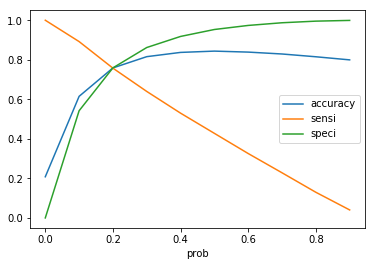

In [76]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

## From curve above optimal cutoff is 0.25

In [77]:
y_train_pred_final['final_predicted'] = y_train_pred_final.RainTomorrow_Prob.map( lambda x: 1 if x > 0.25 else 0)

y_train_pred_final.head()

,RainTomorrow,RainTomorrow_Prob,Date,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.111610,2009-11-24,0,1,1,0,0,0,0,0,0,0,0,0
1,1,0.858574,2016-08-24,1,1,1,1,1,1,1,1,1,1,0,1
2,0,0.243334,2010-07-31,0,1,1,1,0,0,0,0,0,0,0,0
3,0,0.119488,2015-07-03,0,1,1,0,0,0,0,0,0,0,0,0
4,1,0.354067,2010-03-07,0,1,1,1,1,0,0,0,0,0,0,1


In [78]:
# Let's check the overall accuracy.
#metrics.accuracy_score(y_train_pred_final.RainTomorrow, y_train_pred_final.final_predicted)

## Decision Tree Classifier:

In [79]:
# lets build decision tree:
# As decision tree are robost to outliers so we are not treating it.
# we have taken data in which only missing value treatment is done.
Aus_Rain_Classify.head()

,MinTemp,MaxTemp,Rainfall,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Temp9am,Temp3pm,Location,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow
Date,,,,,,,,,,,,,,,,,,
2008-12-01,13.4,22.9,0.6,20.0,24.0,71.0,22.0,16.9,21.8,Albury,W,44.0,W,WNW,1007.7,1007.1,No,No
2008-12-02,7.4,25.1,0.0,4.0,22.0,44.0,25.0,17.2,24.3,Albury,WNW,44.0,NNW,WSW,1010.6,1007.8,No,No
2008-12-03,12.9,25.7,0.0,19.0,26.0,38.0,30.0,21.0,23.2,Albury,WSW,46.0,W,WSW,1007.6,1008.7,No,No
2008-12-04,9.2,28.0,0.0,11.0,9.0,45.0,16.0,18.1,26.5,Albury,NE,24.0,SE,E,1017.6,1012.8,No,No
2008-12-05,17.5,32.3,1.0,7.0,20.0,82.0,33.0,17.8,29.7,Albury,W,41.0,ENE,NW,1010.8,1006.0,No,No


##### let us deal with the categorical variable here:
##### As decision tree easily process categorical variable , here we will use label encoding to encode Categorical variable to standard format:

In [80]:
Aus_Rain_Classify.shape

(139058, 18)

In [81]:
# Selecting all categorical variable:
Aus_Category = Aus_Rain_Classify.select_dtypes(include = ['object'])
Aus_Category.head()

,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
Date,,,,,,
2008-12-01,Albury,W,W,WNW,No,No
2008-12-02,Albury,WNW,NNW,WSW,No,No
2008-12-03,Albury,WSW,W,WSW,No,No
2008-12-04,Albury,NE,SE,E,No,No
2008-12-05,Albury,W,ENE,NW,No,No


In [82]:
#Applying label encoding:
le = preprocessing.LabelEncoder()
Aus_Category = Aus_Category.apply(le.fit_transform)
Aus_Category.head()

,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
Date,,,,,,
2008-12-01,2,13,13,14,0,0
2008-12-02,2,14,6,15,0,0
2008-12-03,2,15,13,15,0,0
2008-12-04,2,4,9,0,0,0
2008-12-05,2,13,1,7,0,0


In [83]:
# Cancatinating Aus_Category to Aus_Rain_Calssify
Aus_Rain_Classify = Aus_Rain_Classify.drop(Aus_Category.columns, axis = 1)
Aus_Rain_Classify = pd.concat([Aus_Rain_Classify, Aus_Category], axis = 1)
Aus_Rain_Classify.head()

,MinTemp,MaxTemp,Rainfall,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Temp9am,Temp3pm,WindGustSpeed,Pressure9am,Pressure3pm,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
Date,,,,,,,,,,,,,,,,,,
2008-12-01,13.4,22.9,0.6,20.0,24.0,71.0,22.0,16.9,21.8,44.0,1007.7,1007.1,2,13,13,14,0,0
2008-12-02,7.4,25.1,0.0,4.0,22.0,44.0,25.0,17.2,24.3,44.0,1010.6,1007.8,2,14,6,15,0,0
2008-12-03,12.9,25.7,0.0,19.0,26.0,38.0,30.0,21.0,23.2,46.0,1007.6,1008.7,2,15,13,15,0,0
2008-12-04,9.2,28.0,0.0,11.0,9.0,45.0,16.0,18.1,26.5,24.0,1017.6,1012.8,2,4,9,0,0,0
2008-12-05,17.5,32.3,1.0,7.0,20.0,82.0,33.0,17.8,29.7,41.0,1010.8,1006.0,2,13,1,7,0,0


In [84]:
Aus_Rain_Classify.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 139058 entries, 2008-12-01 to 2017-06-24
Data columns (total 18 columns):
MinTemp          139058 non-null float64
MaxTemp          139058 non-null float64
Rainfall         139058 non-null float64
WindSpeed9am     139058 non-null float64
WindSpeed3pm     139058 non-null float64
Humidity9am      139058 non-null float64
Humidity3pm      139058 non-null float64
Temp9am          139058 non-null float64
Temp3pm          139058 non-null float64
WindGustSpeed    139058 non-null float64
Pressure9am      139058 non-null float64
Pressure3pm      139058 non-null float64
Location         139058 non-null int64
WindGustDir      139058 non-null int64
WindDir9am       139058 non-null int64
WindDir3pm       139058 non-null int64
RainToday        139058 non-null int64
RainTomorrow     139058 non-null int64
dtypes: float64(12), int64(6)
memory usage: 25.2 MB


In [85]:
# Converting target variable - RainTomorrow to category
Aus_Rain_Classify['RainTomorrow'] = Aus_Rain_Classify['RainTomorrow'].astype('category')

## Model Building:

In [86]:
X, y = Aus_Rain_Classify.drop('RainTomorrow', axis=1), Aus_Rain_Classify.RainTomorrow
X.head()

,MinTemp,MaxTemp,Rainfall,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Temp9am,Temp3pm,WindGustSpeed,Pressure9am,Pressure3pm,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday
Date,,,,,,,,,,,,,,,,,
2008-12-01,13.4,22.9,0.6,20.0,24.0,71.0,22.0,16.9,21.8,44.0,1007.7,1007.1,2,13,13,14,0
2008-12-02,7.4,25.1,0.0,4.0,22.0,44.0,25.0,17.2,24.3,44.0,1010.6,1007.8,2,14,6,15,0
2008-12-03,12.9,25.7,0.0,19.0,26.0,38.0,30.0,21.0,23.2,46.0,1007.6,1008.7,2,15,13,15,0
2008-12-04,9.2,28.0,0.0,11.0,9.0,45.0,16.0,18.1,26.5,24.0,1017.6,1012.8,2,4,9,0,0
2008-12-05,17.5,32.3,1.0,7.0,20.0,82.0,33.0,17.8,29.7,41.0,1010.8,1006.0,2,13,1,7,0


In [87]:
# Splitting test train data set:

X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state = 99)
X_train_C.head()

,MinTemp,MaxTemp,Rainfall,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Temp9am,Temp3pm,WindGustSpeed,Pressure9am,Pressure3pm,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday
Date,,,,,,,,,,,,,,,,,
2010-11-23,23.5,36.4,0.0,13.0,13.0,34.0,20.0,27.6,35.9,35.000000,1015.6,1012.2,0,3,5,13,0
2009-09-13,17.3,32.2,0.0,20.0,13.0,24.0,17.0,25.2,31.9,39.968971,1019.6,1015.5,37,13,6,0,0
2009-06-23,9.2,14.4,0.0,20.0,20.0,57.0,61.0,10.6,14.1,54.000000,1011.2,1008.6,0,7,3,6,0
2011-09-27,12.5,21.3,1.0,4.0,28.0,64.0,63.0,17.8,17.9,50.000000,1023.1,1018.8,26,5,3,4,0
2009-09-29,8.1,14.3,2.0,13.0,20.0,86.0,61.0,10.6,13.4,33.000000,1008.8,1007.9,32,15,3,15,1


In [88]:
dt_1 = DecisionTreeClassifier(random_state=100)
dt_1.fit(X_train_C, y_train_C)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [89]:
# Making predictions
y_pred = dt_1.predict(X_test_C)

In [90]:
print(accuracy_score(y_test_C,y_pred))

0.7833788772232609


In [91]:
print(list(zip(X_train_C.columns, dt_1.feature_importances_)))

[('MinTemp', 0.052784194106106595), ('MaxTemp', 0.04467639754930727), ('Rainfall', 0.047387606900404416), ('WindSpeed9am', 0.03465813699893272), ('WindSpeed3pm', 0.040654093144178546), ('Humidity9am', 0.04885080753060297), ('Humidity3pm', 0.28463508418986366), ('Temp9am', 0.048062453681156206), ('Temp3pm', 0.04777280466749783), ('WindGustSpeed', 0.07256116305219913), ('Pressure9am', 0.05171338028845226), ('Pressure3pm', 0.07675429181076757), ('Location', 0.04633288789386512), ('WindGustDir', 0.03266263225937112), ('WindDir9am', 0.032634077861876), ('WindDir3pm', 0.035004511236460326), ('RainToday', 0.00285547682895828)]


# Random Forest Classifier.

In [92]:
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train_C,y_train_C)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [93]:
# Predict
predictions = rfc.predict(X_test_C)
print(accuracy_score(y_test_C,predictions))

0.8539958770794381


In [94]:
print(list(zip(X_train.columns, rfc.feature_importances_)))

[('WindGustDir_ENE', 0.05567403787406891), ('WindGustDir_ESE', 0.05237662365467477), ('WindGustDir_N', 0.06539375529704375), ('WindGustDir_NE', 0.036825495002498224), ('WindGustDir_NNE', 0.040455273059054005), ('WindGustDir_NNW', 0.06618810416786335), ('WindGustDir_NW', 0.20361219644543382), ('WindGustDir_S', 0.051905227073159234), ('WindGustDir_SE', 0.05737782059913381), ('WindGustDir_SSE', 0.06519308044733868), ('WindGustDir_SSW', 0.0634292927766224), ('WindGustDir_SW', 0.07156559767183673), ('WindGustDir_W', 0.04218402876771617), ('WindGustDir_WNW', 0.03316806802482), ('WindGustDir_WSW', 0.033797748255449775), ('WindDir9am_ENE', 0.03444798762119659), ('WindDir9am_ESE', 0.02640566326208966)]


## we can see that accuracy of Logistic Regression = 0.8438
## Accuracy of Decision Tree Classifier = 0.7833
## Accuracy of Random Forest Classifier = 0.8430
### We can see Logistic Regression and Random Forest are doing equally well.
### Lets Do model evalution on logistic regression and random forest.

# Model Evaluation for logistic regression:

In [95]:
# Model Evalution of Logistic Regression:
# Lets Build Confusion Matrix:
X_test[Num_var] = scaler.transform(X_test[Num_var])
X_test = X_test[col]
X_test.head()

,WindDir3pm_NE,WindDir3pm_NNW,Humidity3pm,WindGustSpeed,Pressure3pm,RainToday
Date,,,,,,
2010-03-15,0,0,-0.152079,0.344227,-0.703202,0
2008-12-10,0,0,-1.042537,0.006521,-0.966829,1
2015-12-06,0,0,0.441560,-0.162333,-0.020875,0
2014-05-13,0,0,-1.537235,-0.753320,1.266243,0
2013-01-20,0,0,0.392090,-0.922173,0.087677,0


In [96]:
X_test_sm = sm.add_constant(X_test)


In [97]:
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]


Date
2010-03-15    0.150286
2008-12-10    0.085608
2015-12-06    0.184214
2014-05-13    0.007164
2013-01-20    0.125640
2009-10-12    0.960964
2008-12-28    0.100240
2009-06-24    0.880732
2011-12-06    0.111756
2009-03-11    0.033141
dtype: float64

In [98]:
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()

,0
Date,
2010-03-15,0.150286
2008-12-10,0.085608
2015-12-06,0.184214
2014-05-13,0.007164
2013-01-20,0.125640


In [99]:
y_test_df = pd.DataFrame(y_test)
y_test_df['Date'] = y_test_df.index
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final.head()

,RainTomorrow,Date,0
0,0,2010-03-15,0.150286
1,0,2008-12-10,0.085608
2,0,2015-12-06,0.184214
3,0,2014-05-13,0.007164
4,0,2013-01-20,0.125640


In [100]:
y_pred_final= y_pred_final.rename(columns={ 0 : 'RainTomorrow_Prob'})
y_pred_final = y_pred_final.reindex_axis(['Date','RainTomorrow','RainTomorrow_Prob'], axis=1)
y_pred_final.head()

,Date,RainTomorrow,RainTomorrow_Prob
0,2010-03-15,0,0.150286
1,2008-12-10,0,0.085608
2,2015-12-06,0,0.184214
3,2014-05-13,0,0.007164
4,2013-01-20,0,0.125640


In [101]:
y_pred_final['final_predicted'] = y_pred_final.RainTomorrow_Prob.map(lambda x: 1 if x > 0.25 else 0)
metrics.accuracy_score(y_pred_final.RainTomorrow, y_pred_final.final_predicted)

0.7939110070257611

In [102]:
confusion2 = metrics.confusion_matrix(y_pred_final.RainTomorrow, y_pred_final.final_predicted )
confusion2

array([[25746,  5704],
       [ 2480,  5781]])

In [103]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives
print(TP / float(TP+FN)) # sensitivity
print(TN / float(TN+FP)) # specificity

0.6997942137755719
0.8186327503974563


In [104]:
# Roc
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [105]:
fpr, tpr, thresholds = metrics.roc_curve( y_pred_final.RainTomorrow, y_pred_final.final_predicted, drop_intermediate = False )

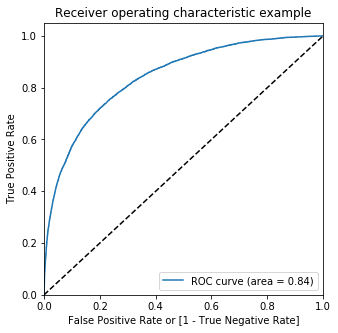

In [106]:
draw_roc(y_pred_final.RainTomorrow, y_pred_final.RainTomorrow_Prob)

### Auc Score For logistic regression is 84%

## Model Evaluation for random forest:


In [107]:
# Selecting important features:
feature_importance_rfc = pd.DataFrame(rfc.feature_importances_,index=X_train_C.columns,columns=['Importance']).sort_values(['Importance'],ascending=False)
feature_importance_rfc.head(6)

,Importance
Humidity3pm,0.203612
Pressure3pm,0.071566
Humidity9am,0.066188
Rainfall,0.065394
WindGustSpeed,0.065193
Pressure9am,0.063429


In [108]:
confusion3 = confusion_matrix(y_test_C,predictions)
confusion3

array([[30969,  1426],
       [ 4665,  4658]])

In [109]:
TP = confusion3[1,1] # true positive 
TN = confusion3[0,0] # true negatives
FP = confusion3[0,1] # false positives
FN = confusion3[1,0] # false negatives
print(TP / float(TP+FN)) # sensitivity
print(TN / float(TN+FP)) # specificity

0.4996245843612571
0.9559808612440192


In [110]:
#Random Forest with these feature:
X_train_fin, X_test_fin, y_train_fin, y_test_fin = train_test_split(X[feature_importance_rfc.head(7).index], y, test_size=0.30, random_state=90)
rfc.fit(X_train_fin,y_train_fin)
y_pred_fin = rfc.predict(X_test_fin)
predictions_1 = rfc.predict_proba(X_test_fin)
print(accuracy_score(y_test_fin,y_pred_fin))

0.8466129728174888


In [111]:
# Confusion matrix without optimal cutoff:
confusion4 = confusion_matrix(y_test_fin,y_pred_fin)
confusion4

array([[30731,  1754],
       [ 4645,  4588]])

In [112]:
TP = confusion4[1,1] # true positive 
TN = confusion4[0,0] # true negatives
FP = confusion4[0,1] # false positives
FN = confusion4[1,0] # false negatives
print(TP / float(TP+FN)) # sensitivity
print(TN / float(TN+FP)) # specificity

0.4969132459655583
0.946005848853317


In [113]:
# Let s get the roc auc score

print(roc_auc_score(y_test_fin,predictions_1[:,1]))



0.8640526855232704


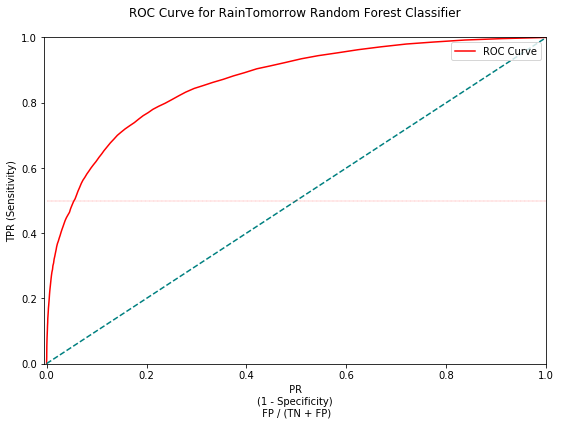

In [114]:
fpr, tpr, thresholds = roc_curve(y_test_fin,predictions_1[:,1])
fig,ax1 = plt.subplots(figsize=(9,6))
ax1.plot(fpr, tpr,color='red')
ax1.legend(['ROC Curve'],loc=1)
ax1.set_xlim([-0.005, 1.0])
ax1.set_ylim([0,1])
ax1.set_ylabel('TPR (Sensitivity)')
ax1.set_xlabel(' PR \n(1 - Specificity)\n FP / (TN + FP)')
ax1.set_title('ROC Curve for RainTomorrow Random Forest Classifier\n')

plt.plot([0,1],[0,1],linestyle='--',color='teal')
plt.plot([0,1],[0.5,0.5],linestyle='--',color='red',linewidth=0.25)

In [115]:
# Function to calc sensitivity and specificity rate for a given threshold
def evaluate_threshold(threshold):
    print('Sensitivity: {:.2%}'.format(tpr[thresholds > threshold][-1]))
    print('Specificity: {:.2%}'.format(1 - fpr[thresholds > threshold][-1]))
    
evaluate_threshold(0.25)

Sensitivity: 76.01%
Specificity: 80.67%


In [116]:
from sklearn.preprocessing import binarize
# change the predicted class with 25% threshold
y_pred_class = binarize(predictions_1,0.25)[:,1]
print(accuracy_score(y_test_fin,y_pred_class))

0.7964188120235869
